# MEWpy example

Increasing the production of succinate in E.coli by modifying genes expression.

We start by loading the Genome-scale Metabolic Model using REFRAMED or COBRApy.

In [1]:
from cobra.io.sbml import read_sbml_model

model = read_sbml_model('models/ec/e_coli_core.xml.gz')

and import the required modules.

In [2]:
from mewpy.optimization.evaluation import BPCY,WYIELD
from mewpy.problems import GOUProblem
from mewpy.simulation import get_simulator

We may have a quick look into the reactions included in the model

In [3]:
sim = get_simulator(model)
sim.find(['BIOMASS','EX_o2_','EX_glc_','EX_succ_']).drop(columns=['stoichiometry','gpr','annotations'])

,name,lb,ub
id,,,
BIOMASS_Ecoli_core_w_GAM,Biomass Objective Function with GAM,0.0,1000.0
EX_glc__D_e,D-Glucose exchange,-10.0,1000.0
EX_o2_e,O2 exchange,-1000.0,1000.0
EX_succ_e,Succinate exchange,0.0,1000.0


We can now define the optimization problem by defining the medium and objective functions, BPCY and WYIELD.

In [4]:
BIOMASS_ID = 'BIOMASS_Ecoli_core_w_GAM'
O2 = 'EX_o2_e'
GLC = 'EX_glc__D_e'
PRODUCT_ID = 'EX_succ_e'
sim.objective = BIOMASS_ID

evaluator_1 = BPCY(BIOMASS_ID, PRODUCT_ID, method = 'lMOMA')
evaluator_2 = WYIELD(BIOMASS_ID,PRODUCT_ID)

medium = {GLC:(-10,1000),O2:(-20,1000)}

We instantiate the problem, a gene over/under expression problem.

In [5]:
problem = GOUProblem(model,
                     [evaluator_1,evaluator_2],
                     envcond=medium,
                     candidate_min_size=2,
                     candidate_max_size=6
                     )

An EA optimizer is instantiated for the defined optimization problem and ran. The `max_generations` value depends on the difficulty and size of the solution space. For illustrative purposes, we only will consider 10 iterations.

In [6]:
from mewpy.optimization import EA
import warnings
warnings.filterwarnings("ignore")
ea = EA(problem, max_generations= 20)
final_pop = ea.run()

Running NSGAII
Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  4.176218  0.027958  0.085566  0.413395|
    200|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.023941  4.176218  0.091307  0.167364  0.575745|
    300|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.103086  4.361139  0.103086  0.325617  0.896205|
    400|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.103086  4.361139  0.105533  0.737138  1.439676|
    500|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.112671  4.361139  0.137993  1.769197  1.956861|
    600|  0.000000  2.502324  0.000000  0.025023  0.248978|  2.660304  7.365741  4.176218  4.198621  0.427755|
    700|  0.000000  2.502324  0.000000  0.100093  0.490353|  4.176218  7.365741  4.361139  4.409516  0.609786|
    800|  0.000000  2.502324  0.000000  0.250232  0.750697|  4.361139  7.365741  4.361139  4.6615

In [7]:
ea.dataframe()

,Modification,Size,BPCY,WYIELD
0,"{'b4090': 0.03125, 'b3236': 2, 'b2914': 0, 'b0...",4,0.774104,8.248792
1,"{'b3236': 2, 'b0721': 0.03125}",2,2.502324,7.365741
2,"{'b3236': 2, 'b3732': 0, 'b0721': 0}",3,1.476403,7.617307
3,"{'b1136': 0.03125, 'b3236': 2, 'b0721': 0}",3,1.032442,8.146401
4,"{'b3236': 2, 'b0721': 0}",2,2.405245,7.602300
5,"{'b1136': 0.03125, 'b3236': 2, 'b0721': 0}",3,1.032442,8.146401
6,"{'b3236': 2, 'b1603': 0, 'b0721': 0}",3,2.024576,7.602300
7,"{'b3236': 2, 'b0721': 0.25}",2,2.870729,5.709827
8,"{'b3236': 2, 'b0721': 0}",2,2.405245,7.602300
9,"{'b3236': 2, 'b0721': 0.125}",2,2.726887,6.656063


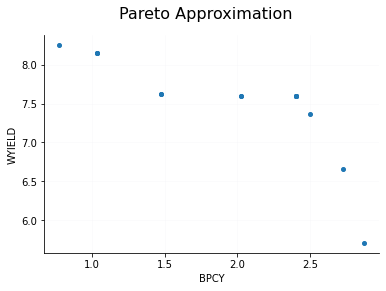

In [10]:
ea.plot()

In [8]:
final_pop[0].values

{'b4090': 0.03125, 'b3236': 2, 'b2914': 0, 'b0721': 0}

In [9]:
res = problem.simulate(solution=final_pop[0].values,method='pFBA')
res.find([PRODUCT_ID,BIOMASS_ID])

,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM,0.101954
EX_succ_e,7.592670
